# Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import squarify
import spacy
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

Download and load catalan stopwords from `spacy`.

In [2]:
!python -m spacy download ca_core_news_sm
nlp = spacy.load("ca_core_news_sm")
stopwords = nlp.Defaults.stop_words
print(stopwords)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 5.7 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('ca_core_news_sm')
{'fa', 'mode', 'van', 'encara', 'teu', 'ells', 'tan', 'són', 'ans', 'nosaltres', 'sota', "t'he", 'aquella', 'ma', 'poder', 'ha', 'hi', "d'una", 'etc', 'ets', 'mentre', 'seu', 'teva', 'també', 'la', 'poca', 'poc', 'unes', 'et', 'i', "d'unes", 'mons', 'tot', 'tenim', 'malgrat', 'aleshores', 'te', 'estan', 'ta', 'amb', 'què', 'feu', 'havia', 'aquestes', 'perquè', 'primer', 'teves', 'en', 'jo', 'esteu', 'molta', 'aquelles', 'e', 'saber', 'tanta', 'aquests', 'és', 'un', 'pocs', 'aquesta', 'cadascuns', 'contra', 'dalt', 'sa', 'sap', 'conseguim', 'estàveu', "n'he", 'tantes', 'solament', 'he', 'dintre', 'son', "m'he", 'seves', 'altres', 'sou', 'molts', 'bé', 'podeu', 'potser', 'tota', 'consigueix', 'dels', 'entre', 'esta', 'així', 'cadascuna', 'haver', 'allà', 'dins', 'pel', 'ser', 'ses', 'tenir', 'éreu', 

# Load and process csv data

In [3]:
data = pd.read_csv('../data/train.csv')

In [4]:
texts = data['text']
labels = data['class']
year = data['year']

## Remove stopwords + leading and trailing quotes

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

preprocessed_texts = []
for sentence in texts:
    preprocessed_texts.append(preprocess_text(sentence))

In [6]:
print(np.random.choice(preprocessed_texts, 15, replace=False))

['convocatria subvencions suficincia alimentria lescola bressol'
 'aprovaci definitiva lexpedient modificaci plantilla personal'
 'notificacin acuerdo iniciacin expediente armas'
 'notificaci desestimaci propostes dactivitat empresarial arribar puntuaci mnima valoraci daspectes tcnics'
 'convocatria vacant crrec jutge pau titular'
 'aprovaci definitiva pla especial urbanstic dadequaci ds equipaments existents'
 'aprovaci inicial lordenana reguladora prestaci patrimonial carcter tributari servei municipal subministrament domiciliari daigua potable'
 'contractaci servei realitzaci dun estudi lestat conservaci patologies existents aparcaments gestionats farga as'
 'notificaci requeriment obres faana ledifici industrial emplaat c colom cantonada c rafael roig imposici duna multa coercitiva'
 'modificaci relaci llocs treball' 'delegacio funcions dalcaldia'
 'aprovaci definitiva projecte dobres ordinries rehabilitaci adoberies bella bernades digualada centre europeu pell qualitat'
 'aprovaci

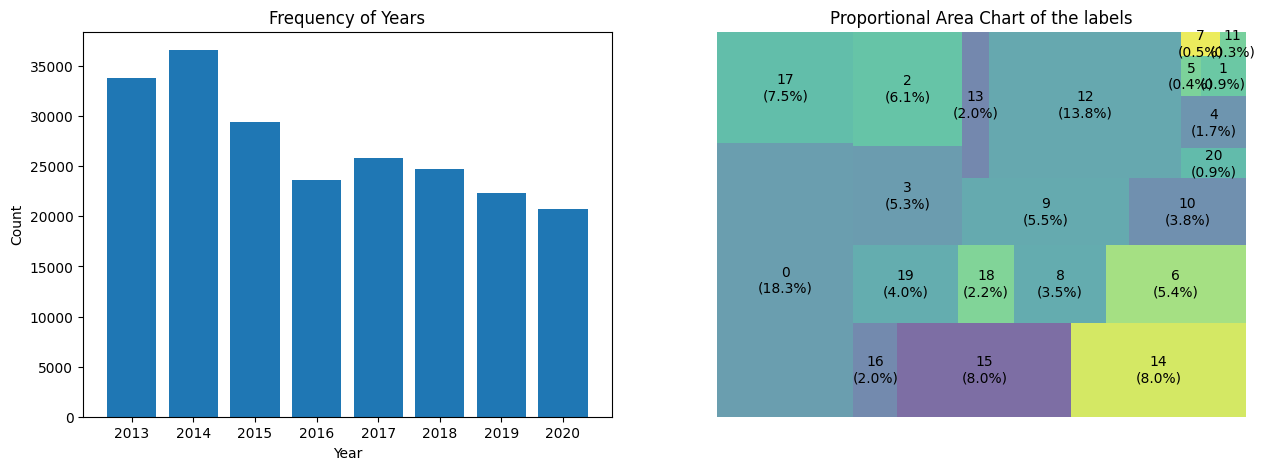

In [7]:
year_counts = Counter(year)
sorted_years = sorted(year_counts)
frequencies_years = [year_counts[year] for year in sorted_years]

lable_counts = Counter(labels)
sorted_lables = sorted(lable_counts)
frequencies_labels = [lable_counts[label] for label in sorted_lables]
labels_with_pct = [f"{label}\n({size/sum(frequencies_labels):.1%})" for label, size in lable_counts.items()]

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].bar(sorted_years, frequencies_years)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].set_title('Frequency of Years')


squarify.plot(sizes=lable_counts.values(), label=labels_with_pct, alpha=0.7, ax=ax[1])
ax[1].axis('off')
ax[1].set_title("Proportional Area Chart of the labels")

# ax[1].bar(sorted_lables, frequencies_labels)
# ax[1].set_xlabel('Label')
# ax[1].set_ylabel('Count')
# ax[1].set_title('Label Frequencies')

plt.show()

## Plot the WordCloud

In [14]:
def TermDocMatrix(corpus):
    vec = TfidfVectorizer(max_features=1000)
    X = vec.fit_transform(corpus)
    df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())
    return df

def CreateWordCloud(tdm,
                    save_file=True,):
    words = tdm.columns  
    word_freq = {}
    for _, row in tdm.iterrows():
        for i, count in enumerate(row):
            word = words[i]
            word_freq[word] = word_freq.get(word, 0) + count

    wordcloud = WordCloud(width=800, height=400,
                        background_color='white').generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    if save_file:
        wordcloud.to_file("first_document.png")
    
    return word_freq

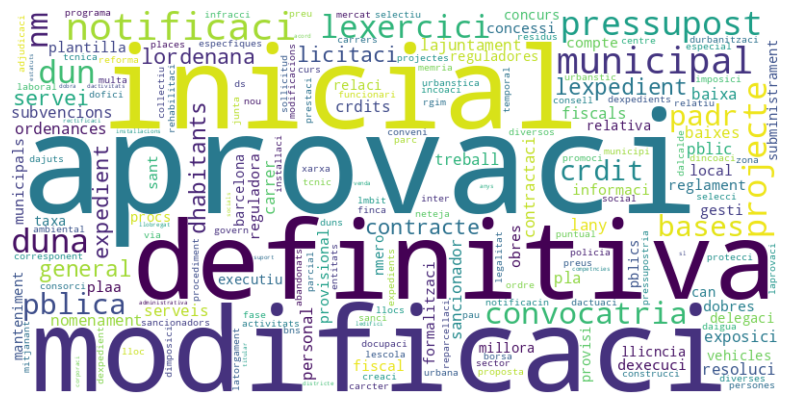

In [15]:
tdm = TermDocMatrix(preprocessed_texts)
word_cloud = CreateWordCloud(tdm, save_file=False)

## Convert texts to TF-IDF vectors

In [8]:
vectorizer = TfidfVectorizer(max_features=1000)

### How many unique words are in texts?

In [13]:
test_vectorizer = TfidfVectorizer()
test_vectorizer.fit(preprocessed_texts)
print(f"Total unique words in corpus: {len(test_vectorizer.vocabulary_)}")

Total unique words in corpus: 26735


In [9]:
X = vectorizer.fit_transform(preprocessed_texts).toarray()
y = np.array(labels)

## Create a PyTorch dataset

In [10]:
class TextDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [11]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

train_dataset = DataLoader(TextDataset(X_train, y_train), batch_size=32, shuffle=True)
test_dataset = DataLoader(TextDataset(X_test, y_test), batch_size=32)

# Basic NN

## Model Class

In [21]:
# Define the FCNN model
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Initialize Model, Loss and Optimizer

In [24]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)
summary(fcnn)

Layer (type:depth-idx)                   Param #
FCNN                                     --
├─Linear: 1-1                            256,256
├─ReLU: 1-2                              --
├─Linear: 1-3                            5,397
Total params: 261,653
Trainable params: 261,653
Non-trainable params: 0

## Training and Testing

In [19]:
def train(model, train_loader, optimizer, history):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * target.size(0)
        running_correct += output.argmax(1).eq(target).sum().item()
        running_total  += target.size(0)

    history["train_loss"].append(running_loss / running_total)
    history["train_accuracy"].append(100.0 * running_correct / running_total)


def test(model, test_loader, history):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            running_loss   += loss_function(output, target).item() * target.size(0)
            running_correct += output.argmax(1).eq(target).sum().item()
            running_total  += target.size(0)

    history["val_loss"].append(running_loss / running_total)
    history["val_accuracy"].append(100.0 * running_correct / running_total)

## History plot

In [12]:
def plot_history(n_epochs, history):
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle("Training Loss and Accuracy")

    # Accuracy plot
    ax1.plot(np.arange(n_epochs), history["train_accuracy"], label="train")
    ax1.plot(np.arange(n_epochs), history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy (%)")
    ax1.legend(loc="lower right")

    # Loss plot
    ax2.plot(np.arange(n_epochs), history["train_loss"],     label="train")
    ax2.plot(np.arange(n_epochs), history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")

    plt.show()

## Fitting function

In [13]:
def fit(model, train_loader, test_loader, optimizer, epochs):
    history = {k: [] for k in ["train_loss", "train_accuracy", "val_loss", "val_accuracy"]}

    for epoch in range(epochs):
        train(model, train_loader, optimizer, history)
        test(model,  test_loader,  history)

        print(f"Epoch {epoch+1:02d}/{epochs} │ "
              f"loss={history['train_loss'][-1]:.4f}  "
              f"val_loss={history['val_loss'][-1]:.4f}  "
              f"acc={history['train_accuracy'][-1]:.2f}%  "
              f"val_acc={history['val_accuracy'][-1]:.2f}%")

    plot_history(epochs, history)
    return history

## Run model

Epoch 01/20 │ loss=0.2980  val_loss=0.1846  acc=91.75%  val_acc=94.45%
Epoch 02/20 │ loss=0.1660  val_loss=0.1743  acc=94.84%  val_acc=94.80%
Epoch 03/20 │ loss=0.1463  val_loss=0.1720  acc=95.33%  val_acc=94.72%
Epoch 04/20 │ loss=0.1309  val_loss=0.1675  acc=95.82%  val_acc=95.02%
Epoch 05/20 │ loss=0.1169  val_loss=0.1693  acc=96.21%  val_acc=95.02%
Epoch 06/20 │ loss=0.1045  val_loss=0.1684  acc=96.61%  val_acc=95.10%
Epoch 07/20 │ loss=0.0927  val_loss=0.1739  acc=96.98%  val_acc=95.02%
Epoch 08/20 │ loss=0.0827  val_loss=0.1746  acc=97.30%  val_acc=95.17%
Epoch 09/20 │ loss=0.0737  val_loss=0.1823  acc=97.59%  val_acc=95.15%
Epoch 10/20 │ loss=0.0652  val_loss=0.1879  acc=97.88%  val_acc=95.01%
Epoch 11/20 │ loss=0.0587  val_loss=0.1944  acc=98.05%  val_acc=95.09%
Epoch 12/20 │ loss=0.0530  val_loss=0.1991  acc=98.20%  val_acc=95.09%
Epoch 13/20 │ loss=0.0485  val_loss=0.2059  acc=98.38%  val_acc=95.15%
Epoch 14/20 │ loss=0.0444  val_loss=0.2138  acc=98.50%  val_acc=95.06%
Epoch 

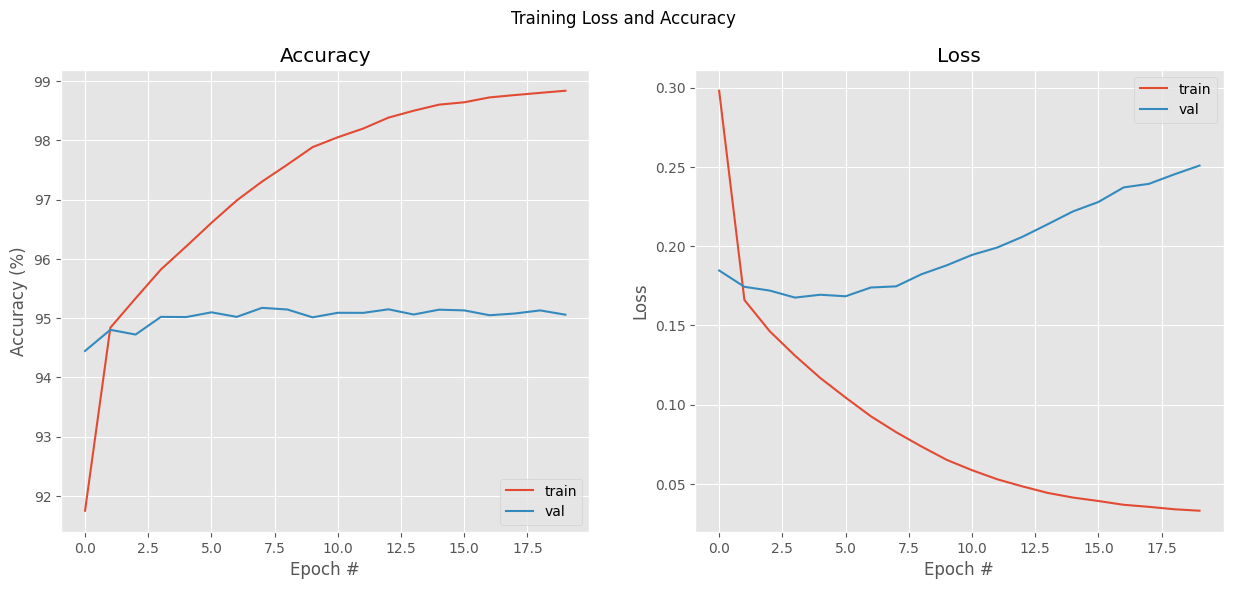

In [19]:
history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

There are clear overfitting issues with this model.

# Transformer model

In [20]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import evaluate
import accelerate

/mnt/d/MEGA/MÀSTER MODELLING/2 - Mathematics for Big Data/3. DeepLearning/MBD_NN/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-10 21:55:12.888285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749585312.951648   18746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749585312.969007   18746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749585313.108672   18746 computation_placer.cc:177] computation placer already registered. Please check

Hugging face BERT-like models expects tokenized inputs (This is done by lazy-tokenization):

In [34]:
df = pd.DataFrame({
    "text": preprocessed_texts,
    "label": labels
})

train_tok, test_tok = train_test_split(df, test_size=0.25,
                                       stratify=labels, random_state=0)

train_tok = Dataset.from_pandas(train_tok)
test_tok   = Dataset.from_pandas(test_tok)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch['text'],
                     padding='max_length',
                     truncation=True
                     )

# Convert to HuggingFace Dataset object to be able to use .map()
# train_dataset = Dataset.from_dict({"text": X_train_tok, "label": y_train_tok})
# test_dataset  = Dataset.from_dict({"text": X_test_tok,  "label": y_test_tok})
train_tok = train_tok.map(tokenize)
test_tok  = test_tok.map(tokenize)

train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 54244/54244 [00:10<00:00, 5329.54 examples/s]


In [35]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=21,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainer wrapping (so it can be used as a sklearn-like model).

In [38]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

args = TrainingArguments(
    output_dir=".outputs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    num_train_epochs=2,           # 2-3 epochs usually fine when fine-tuning
    fp16=True,
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=test_tok,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)

Run the model.

In [39]:
trainer.train()
trainer.evaluate()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.211900,0.201387,0.954742
2,0.147700,0.162076,0.963093


{'eval_loss': 0.16207608580589294,
 'eval_accuracy': 0.9630926922793305,
 'eval_runtime': 136.7285,
 'eval_samples_per_second': 396.728,
 'eval_steps_per_second': 49.595,
 'epoch': 2.0}

FINAL NOTES: since the transformer model DOES NOT perform better than the FCNN, we will modify the FCNN in order to reduce the overfitting issue. We will also try training using per-year data and see its performance when predicting over the following year's data.

# FCNN: Dealing with overfitting

## Adding Dropout layer and Batch Normalization

`Dropout` randomly disables some neurons during training, forcing the model to generalize better whereas `Batch Normalization` helps in stabilizing and regularizing the training, especially in deeper networks.

In [14]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.fc3(out)

        return out

Epoch 01/20 │ loss=0.3564  val_loss=0.1965  acc=90.32%  val_acc=94.18%
Epoch 02/20 │ loss=0.2440  val_loss=0.1798  acc=93.02%  val_acc=94.64%
Epoch 03/20 │ loss=0.2217  val_loss=0.1729  acc=93.61%  val_acc=94.78%
Epoch 04/20 │ loss=0.2071  val_loss=0.1700  acc=93.93%  val_acc=94.90%
Epoch 05/20 │ loss=0.1957  val_loss=0.1699  acc=94.19%  val_acc=95.06%
Epoch 06/20 │ loss=0.1863  val_loss=0.1693  acc=94.47%  val_acc=94.91%
Epoch 07/20 │ loss=0.1786  val_loss=0.1638  acc=94.65%  val_acc=95.09%
Epoch 08/20 │ loss=0.1719  val_loss=0.1641  acc=94.80%  val_acc=95.14%
Epoch 09/20 │ loss=0.1683  val_loss=0.1650  acc=94.93%  val_acc=95.20%
Epoch 10/20 │ loss=0.1627  val_loss=0.1652  acc=95.05%  val_acc=95.23%
Epoch 11/20 │ loss=0.1598  val_loss=0.1662  acc=95.14%  val_acc=95.19%
Epoch 12/20 │ loss=0.1559  val_loss=0.1633  acc=95.25%  val_acc=95.24%
Epoch 13/20 │ loss=0.1526  val_loss=0.1643  acc=95.34%  val_acc=95.29%
Epoch 14/20 │ loss=0.1474  val_loss=0.1666  acc=95.46%  val_acc=95.25%
Epoch 

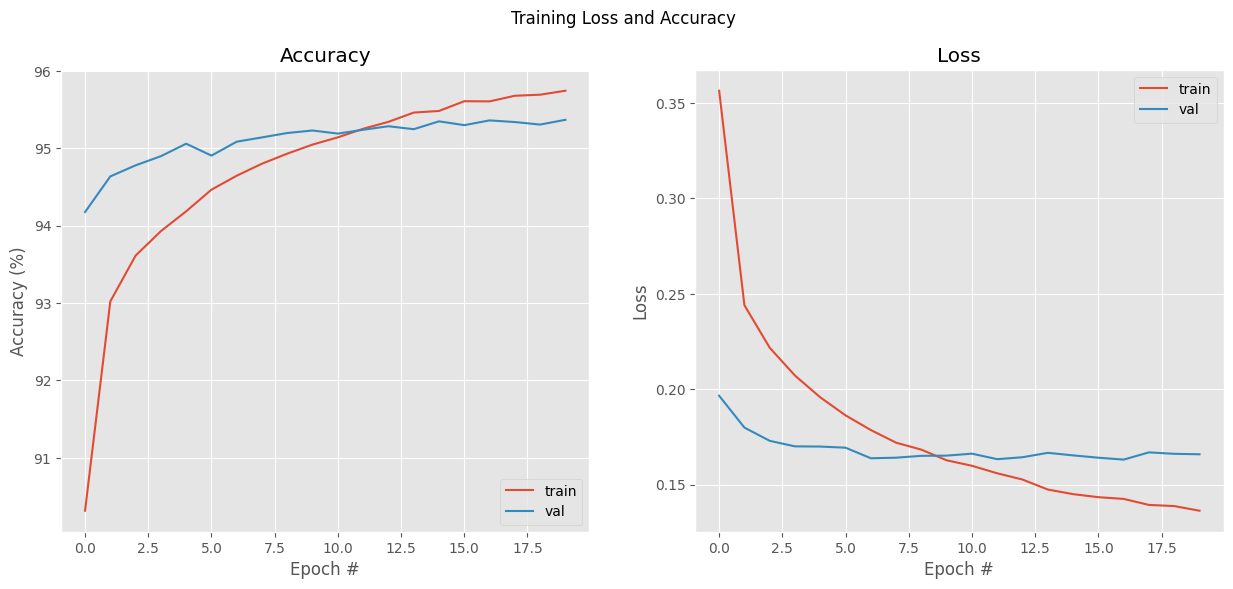

In [20]:
fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
)

We can see the overfitting has improved at the cost of reducing slightly the training accuracy of the model.

## Yearly data distribution for train and testing

Now we will use data from a specific year as the validation set, and data from the previous year as the training set. This approach helps estimate the model’s predictive power on future (unseen) data, simulating how it might perform on the final test set.

Notice we define the vectorizer and the fcnn outside the loop: 
1. We are fiting the vectorizer with the entire preprocess data. 
2. The fcnn has its weights improved in each year.

`train` and `test` functions are modified here so they can be run on GPU.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, history):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0

    for data, target in train_loader:

        # Modifications to send data to GPU
        data = data.to(device).float()
        target = target.to(device).long()
        
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss   += loss.item() * target.size(0)
        running_correct += output.argmax(1).eq(target).sum().item()
        running_total  += target.size(0)

    history["train_loss"].append(running_loss / running_total)
    history["train_accuracy"].append(100.0 * running_correct / running_total)


def test(model, test_loader, history):
    model.eval()
    running_loss, running_correct, running_total = 0.0, 0, 0

    with torch.no_grad():
        for data, target in test_loader:

            # Modifications to send data to GPU
            data = data.to(device).float()
            target = target.to(device).long()
            
            output = model(data)
            running_loss   += loss_function(output, target).item() * target.size(0)
            running_correct += output.argmax(1).eq(target).sum().item()
            running_total  += target.size(0)

    history["val_loss"].append(running_loss / running_total)
    history["val_accuracy"].append(100.0 * running_correct / running_total)

Length Traing data: 33770
Length Test data: 36589
Epoch 01/20 │ loss=0.5196  val_loss=0.2792  acc=86.11%  val_acc=92.10%
Epoch 02/20 │ loss=0.2463  val_loss=0.2639  acc=92.93%  val_acc=92.93%
Epoch 03/20 │ loss=0.2039  val_loss=0.2734  acc=94.05%  val_acc=92.65%
Epoch 04/20 │ loss=0.1822  val_loss=0.2688  acc=94.67%  val_acc=92.59%
Epoch 05/20 │ loss=0.1634  val_loss=0.2727  acc=94.99%  val_acc=93.11%
Epoch 06/20 │ loss=0.1521  val_loss=0.2727  acc=95.34%  val_acc=92.90%
Epoch 07/20 │ loss=0.1400  val_loss=0.2855  acc=95.68%  val_acc=92.67%
Epoch 08/20 │ loss=0.1314  val_loss=0.2816  acc=95.89%  val_acc=92.99%
Epoch 09/20 │ loss=0.1253  val_loss=0.2917  acc=96.02%  val_acc=93.00%
Epoch 10/20 │ loss=0.1148  val_loss=0.3018  acc=96.34%  val_acc=92.93%
Epoch 11/20 │ loss=0.1105  val_loss=0.3140  acc=96.42%  val_acc=92.94%
Epoch 12/20 │ loss=0.1048  val_loss=0.3191  acc=96.62%  val_acc=92.90%
Epoch 13/20 │ loss=0.1004  val_loss=0.3119  acc=96.80%  val_acc=93.02%
Epoch 14/20 │ loss=0.0974  

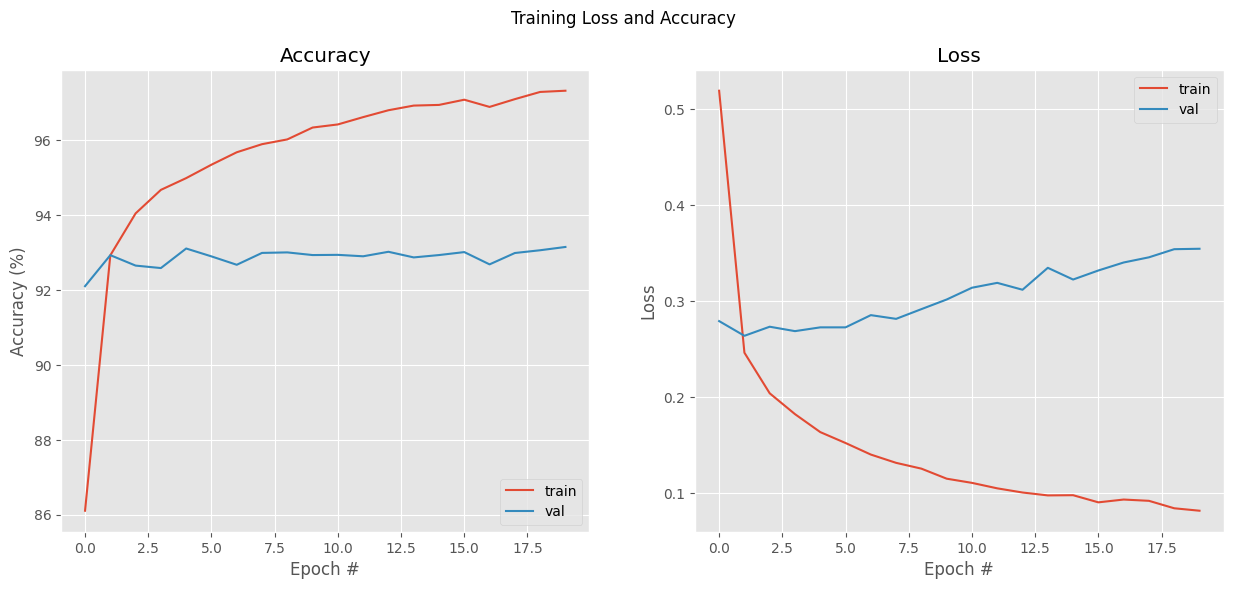

Length Traing data: 70359
Length Test data: 29412
Epoch 01/20 │ loss=0.2157  val_loss=0.2905  acc=94.19%  val_acc=92.08%
Epoch 02/20 │ loss=0.1717  val_loss=0.2497  acc=94.85%  val_acc=93.38%
Epoch 03/20 │ loss=0.1540  val_loss=0.2541  acc=95.34%  val_acc=93.06%
Epoch 04/20 │ loss=0.1464  val_loss=0.2527  acc=95.43%  val_acc=93.18%
Epoch 05/20 │ loss=0.1404  val_loss=0.2650  acc=95.57%  val_acc=93.05%
Epoch 06/20 │ loss=0.1337  val_loss=0.2724  acc=95.72%  val_acc=93.06%
Epoch 07/20 │ loss=0.1277  val_loss=0.2728  acc=95.95%  val_acc=93.36%
Epoch 08/20 │ loss=0.1233  val_loss=0.2716  acc=96.07%  val_acc=93.26%
Epoch 09/20 │ loss=0.1220  val_loss=0.2748  acc=96.06%  val_acc=93.20%
Epoch 10/20 │ loss=0.1195  val_loss=0.2827  acc=96.14%  val_acc=93.27%
Epoch 11/20 │ loss=0.1160  val_loss=0.2763  acc=96.32%  val_acc=93.48%
Epoch 12/20 │ loss=0.1115  val_loss=0.2744  acc=96.40%  val_acc=93.55%
Epoch 13/20 │ loss=0.1125  val_loss=0.2864  acc=96.34%  val_acc=93.31%
Epoch 14/20 │ loss=0.1082  

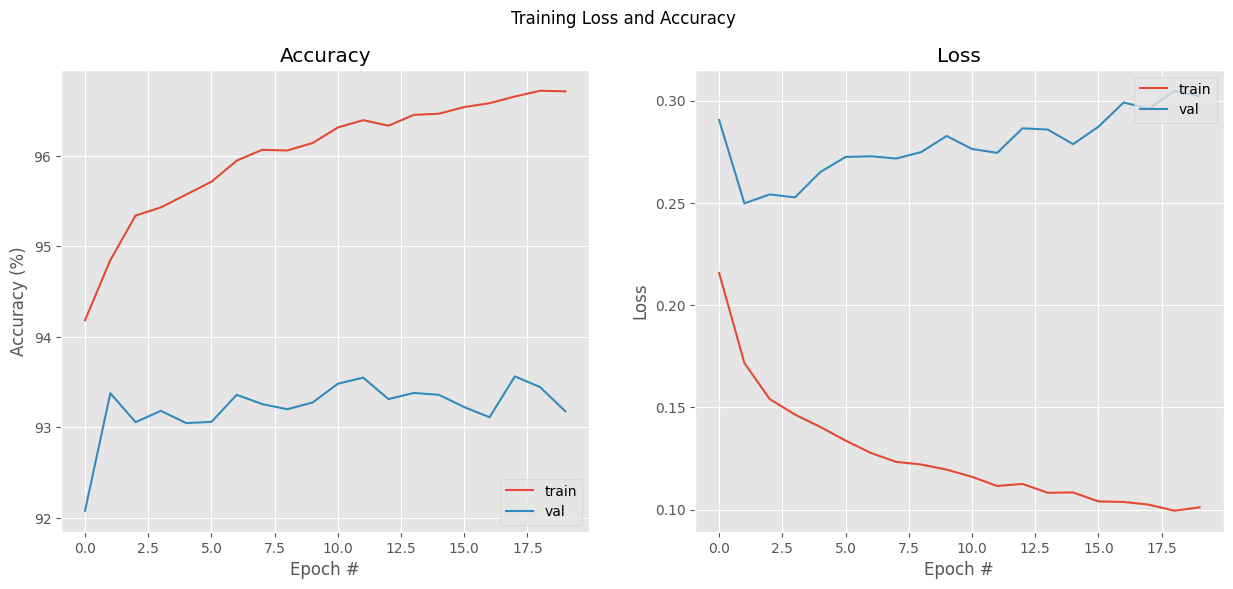

Length Traing data: 99771
Length Test data: 23589
Epoch 01/20 │ loss=0.1653  val_loss=0.2500  acc=95.32%  val_acc=93.49%
Epoch 02/20 │ loss=0.1425  val_loss=0.2424  acc=95.70%  val_acc=93.66%
Epoch 03/20 │ loss=0.1340  val_loss=0.2447  acc=95.89%  val_acc=93.84%
Epoch 04/20 │ loss=0.1300  val_loss=0.2519  acc=95.94%  val_acc=93.93%
Epoch 05/20 │ loss=0.1240  val_loss=0.2551  acc=96.04%  val_acc=93.77%
Epoch 06/20 │ loss=0.1217  val_loss=0.2567  acc=96.13%  val_acc=93.82%
Epoch 07/20 │ loss=0.1206  val_loss=0.2594  acc=96.20%  val_acc=93.95%
Epoch 08/20 │ loss=0.1154  val_loss=0.2555  acc=96.28%  val_acc=93.88%
Epoch 09/20 │ loss=0.1145  val_loss=0.2630  acc=96.32%  val_acc=93.98%
Epoch 10/20 │ loss=0.1126  val_loss=0.2612  acc=96.42%  val_acc=94.00%
Epoch 11/20 │ loss=0.1112  val_loss=0.2703  acc=96.44%  val_acc=93.85%
Epoch 12/20 │ loss=0.1101  val_loss=0.2810  acc=96.47%  val_acc=93.70%
Epoch 13/20 │ loss=0.1085  val_loss=0.2648  acc=96.51%  val_acc=93.90%
Epoch 14/20 │ loss=0.1054  

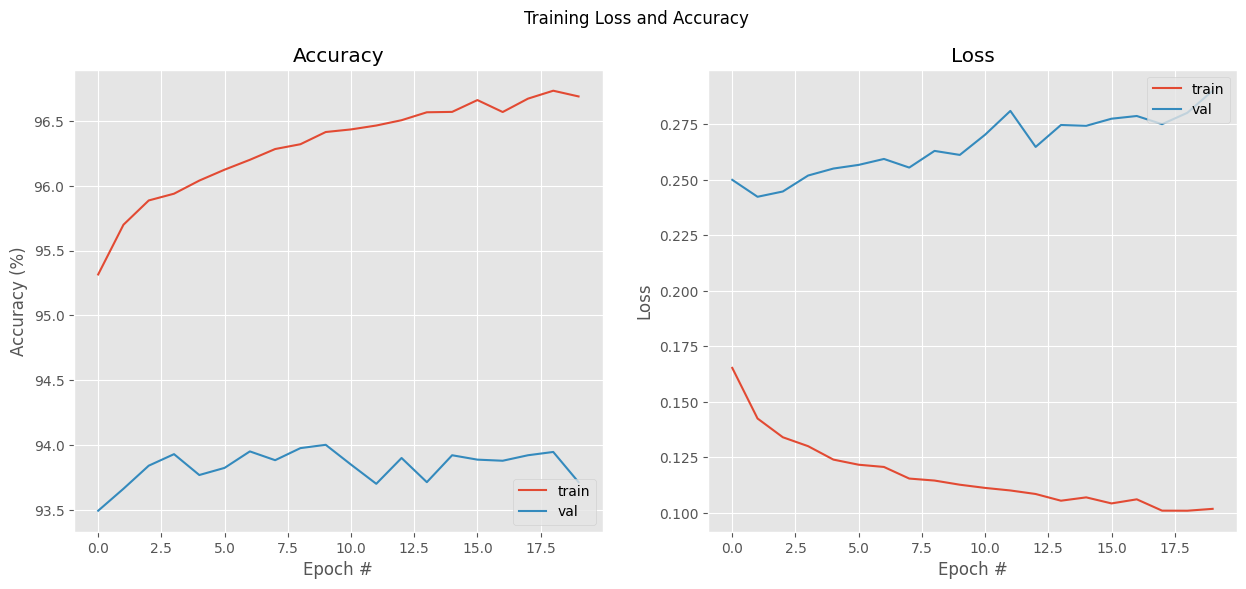

Length Traing data: 123360
Length Test data: 25813
Epoch 01/20 │ loss=0.1450  val_loss=0.2153  acc=95.91%  val_acc=94.66%
Epoch 02/20 │ loss=0.1332  val_loss=0.2141  acc=95.93%  val_acc=94.70%
Epoch 03/20 │ loss=0.1276  val_loss=0.2104  acc=96.08%  val_acc=94.70%
Epoch 04/20 │ loss=0.1243  val_loss=0.2067  acc=96.17%  val_acc=94.88%
Epoch 05/20 │ loss=0.1202  val_loss=0.2131  acc=96.23%  val_acc=94.74%
Epoch 06/20 │ loss=0.1154  val_loss=0.2071  acc=96.39%  val_acc=94.82%
Epoch 07/20 │ loss=0.1152  val_loss=0.2121  acc=96.37%  val_acc=94.75%
Epoch 08/20 │ loss=0.1134  val_loss=0.2120  acc=96.35%  val_acc=94.82%
Epoch 09/20 │ loss=0.1121  val_loss=0.2152  acc=96.39%  val_acc=94.74%
Epoch 10/20 │ loss=0.1125  val_loss=0.2167  acc=96.46%  val_acc=94.89%
Epoch 11/20 │ loss=0.1110  val_loss=0.2234  acc=96.48%  val_acc=94.76%
Epoch 12/20 │ loss=0.1086  val_loss=0.2241  acc=96.53%  val_acc=94.88%
Epoch 13/20 │ loss=0.1073  val_loss=0.2291  acc=96.56%  val_acc=94.65%
Epoch 14/20 │ loss=0.1084 

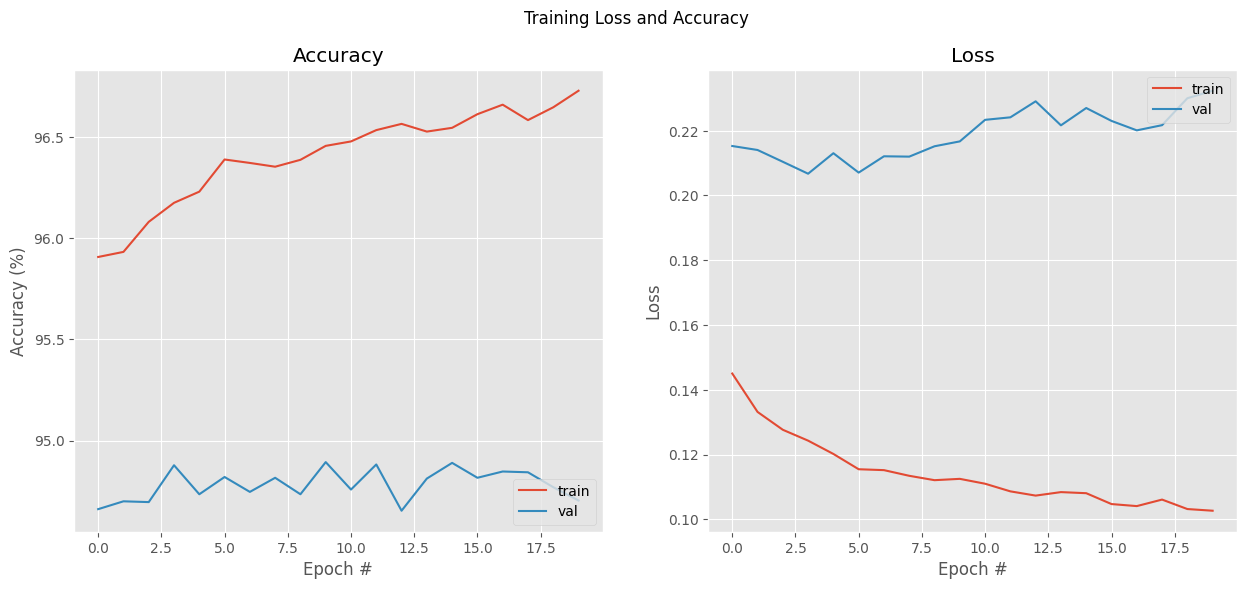

Length Traing data: 149173
Length Test data: 24734
Epoch 01/20 │ loss=0.1377  val_loss=0.2227  acc=96.06%  val_acc=94.29%
Epoch 02/20 │ loss=0.1299  val_loss=0.2111  acc=96.05%  val_acc=94.47%
Epoch 03/20 │ loss=0.1259  val_loss=0.2154  acc=96.19%  val_acc=94.71%
Epoch 04/20 │ loss=0.1217  val_loss=0.2083  acc=96.31%  val_acc=94.74%
Epoch 05/20 │ loss=0.1188  val_loss=0.2129  acc=96.34%  val_acc=94.82%
Epoch 06/20 │ loss=0.1166  val_loss=0.2157  acc=96.39%  val_acc=94.74%
Epoch 07/20 │ loss=0.1177  val_loss=0.2191  acc=96.35%  val_acc=94.74%
Epoch 08/20 │ loss=0.1144  val_loss=0.2194  acc=96.43%  val_acc=94.80%
Epoch 09/20 │ loss=0.1156  val_loss=0.2181  acc=96.42%  val_acc=94.76%
Epoch 10/20 │ loss=0.1135  val_loss=0.2213  acc=96.45%  val_acc=94.69%
Epoch 11/20 │ loss=0.1116  val_loss=0.2250  acc=96.50%  val_acc=94.72%
Epoch 12/20 │ loss=0.1115  val_loss=0.2220  acc=96.49%  val_acc=94.67%
Epoch 13/20 │ loss=0.1096  val_loss=0.2329  acc=96.57%  val_acc=94.73%
Epoch 14/20 │ loss=0.1101 

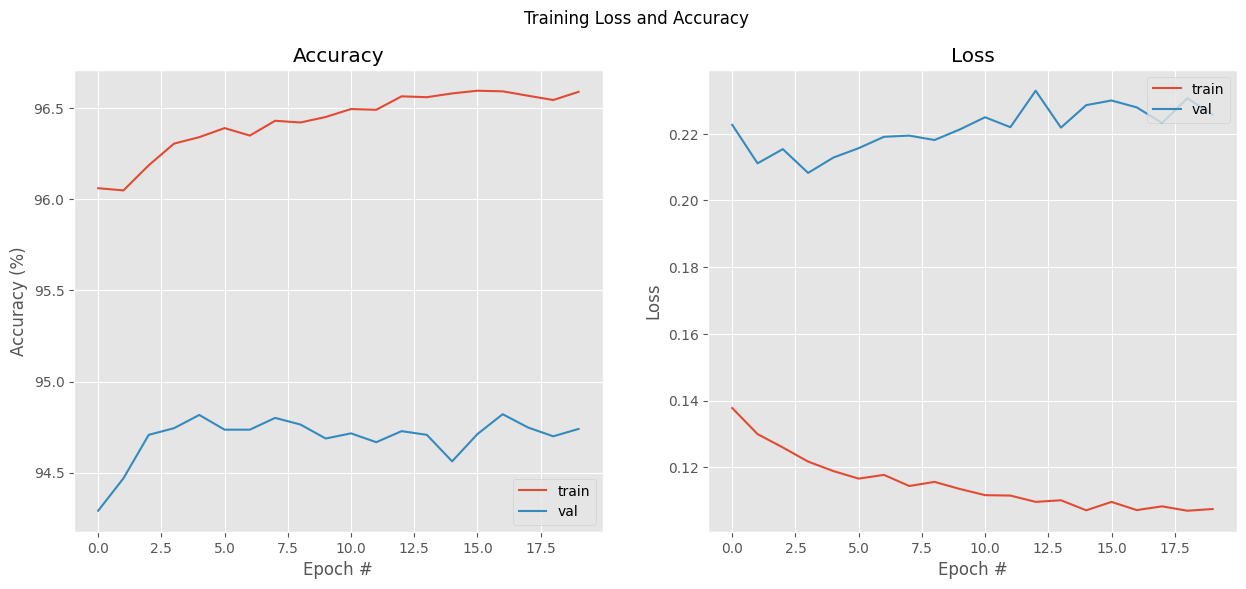

Length Traing data: 173907
Length Test data: 22365
Epoch 01/20 │ loss=0.1324  val_loss=0.1972  acc=96.15%  val_acc=94.78%
Epoch 02/20 │ loss=0.1277  val_loss=0.1926  acc=96.16%  val_acc=94.97%
Epoch 03/20 │ loss=0.1248  val_loss=0.1901  acc=96.20%  val_acc=95.04%
Epoch 04/20 │ loss=0.1221  val_loss=0.1904  acc=96.26%  val_acc=95.05%
Epoch 05/20 │ loss=0.1216  val_loss=0.1918  acc=96.27%  val_acc=95.16%
Epoch 06/20 │ loss=0.1201  val_loss=0.1907  acc=96.29%  val_acc=95.19%
Epoch 07/20 │ loss=0.1164  val_loss=0.1940  acc=96.37%  val_acc=95.07%
Epoch 08/20 │ loss=0.1163  val_loss=0.1902  acc=96.36%  val_acc=95.13%
Epoch 09/20 │ loss=0.1174  val_loss=0.1936  acc=96.38%  val_acc=95.12%
Epoch 10/20 │ loss=0.1157  val_loss=0.1909  acc=96.41%  val_acc=95.26%
Epoch 11/20 │ loss=0.1131  val_loss=0.1975  acc=96.46%  val_acc=95.06%
Epoch 12/20 │ loss=0.1145  val_loss=0.1957  acc=96.40%  val_acc=95.31%
Epoch 13/20 │ loss=0.1133  val_loss=0.1965  acc=96.49%  val_acc=95.27%
Epoch 14/20 │ loss=0.1121 

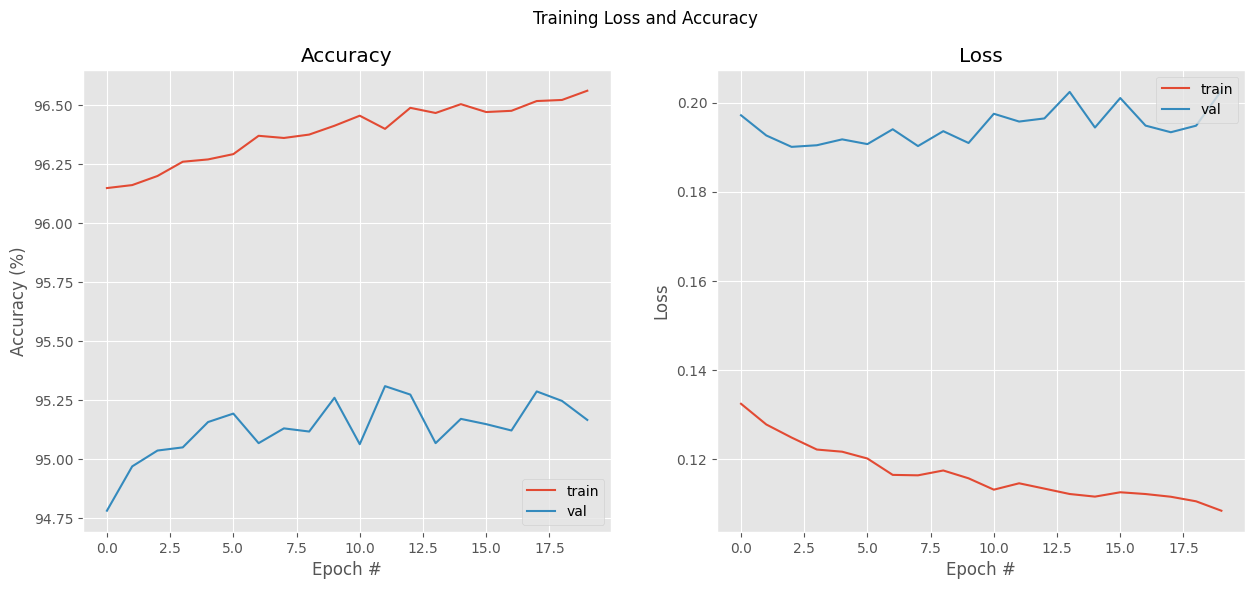

Length Traing data: 196272
Length Test data: 20702
Epoch 01/20 │ loss=0.1278  val_loss=0.2847  acc=96.20%  val_acc=94.05%
Epoch 02/20 │ loss=0.1243  val_loss=0.2862  acc=96.21%  val_acc=94.06%
Epoch 03/20 │ loss=0.1234  val_loss=0.2834  acc=96.32%  val_acc=94.11%
Epoch 04/20 │ loss=0.1199  val_loss=0.2845  acc=96.33%  val_acc=94.03%
Epoch 05/20 │ loss=0.1187  val_loss=0.2854  acc=96.33%  val_acc=94.27%
Epoch 06/20 │ loss=0.1175  val_loss=0.2819  acc=96.38%  val_acc=94.17%
Epoch 07/20 │ loss=0.1191  val_loss=0.2756  acc=96.36%  val_acc=94.11%
Epoch 08/20 │ loss=0.1171  val_loss=0.2901  acc=96.37%  val_acc=94.16%
Epoch 09/20 │ loss=0.1145  val_loss=0.2921  acc=96.45%  val_acc=94.17%
Epoch 10/20 │ loss=0.1153  val_loss=0.2978  acc=96.44%  val_acc=94.16%
Epoch 11/20 │ loss=0.1148  val_loss=0.2954  acc=96.41%  val_acc=94.25%
Epoch 12/20 │ loss=0.1144  val_loss=0.2959  acc=96.45%  val_acc=94.21%
Epoch 13/20 │ loss=0.1144  val_loss=0.2960  acc=96.45%  val_acc=94.23%
Epoch 14/20 │ loss=0.1131 

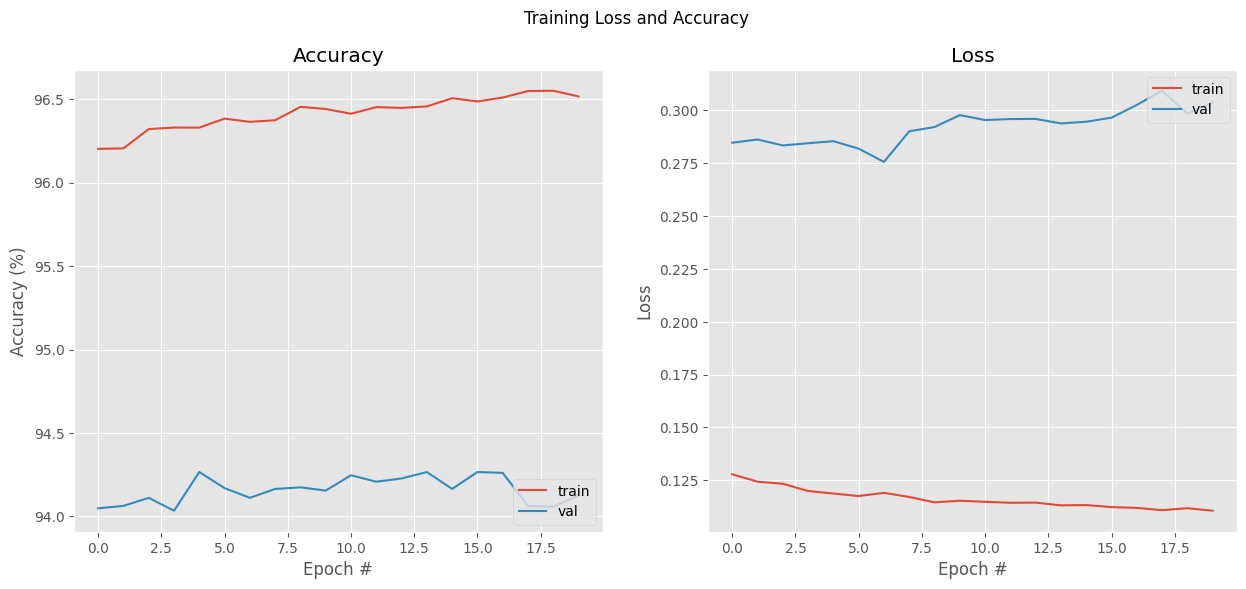

In [16]:
year_num = 2014
val_acc_history = {}

vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(preprocessed_texts)

fcnn = FCNN(input_size=1000, hidden_size=256, num_classes=21).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcnn.parameters(), lr=0.001)

while year_num <= 2020:

    X = vectorizer.transform([text for text, y in zip(preprocessed_texts, year) if y < year_num]).toarray()
    y = np.array([text for text, y_ in zip(labels, year) if y_ < year_num])
    print(f'Length Traing data: {len(y)}')
    train_dataset = DataLoader(TextDataset(X, y), batch_size=32, shuffle=True)

    X = vectorizer.transform([text for text, y in zip(preprocessed_texts, year) if y == year_num]).toarray()
    y = np.array([text for text, y_ in zip(labels, year) if y_ == year_num])
    print(f'Length Test data: {len(y)}')    
    test_dataset = DataLoader(TextDataset(X, y), batch_size=32)

    history = fit(
    model        = fcnn,
    train_loader = train_dataset,
    test_loader  = test_dataset,
    optimizer    = optimizer,
    epochs       = 20
    )

    val_acc_history[year_num] = history['val_accuracy'][-1]

    year_num += 1

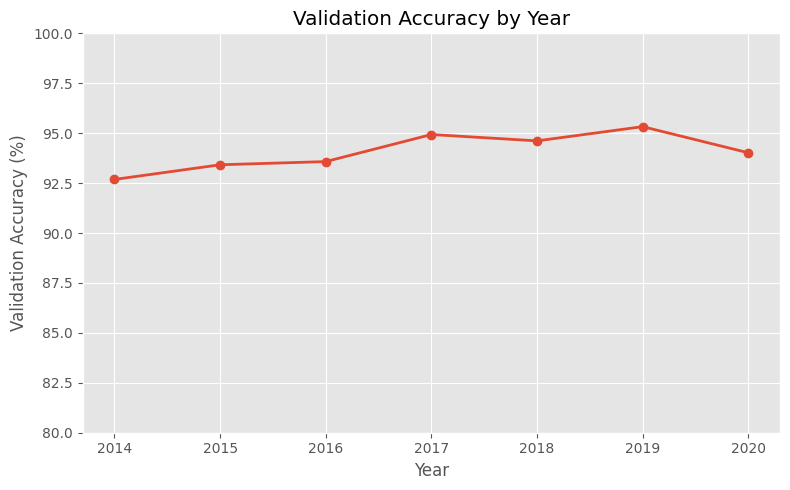

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(list(val_acc_history.keys()),
         list(val_acc_history.values()),
         marker='o',linestyle='-', linewidth=2)
plt.title('Validation Accuracy by Year')
plt.xlabel('Year')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True)
plt.ylim(80, 100)
plt.xticks(list(val_acc_history.keys()))
plt.tight_layout()
plt.show()

In [23]:
from scipy import stats

values = np.array(list(val_acc_history.values()))
n = len(values)
mean = np.mean(values)
std_dev = np.std(values, ddof=1)

t_critical = stats.t.ppf(1 - 0.025, df=n-1)
margin_of_error = t_critical * (std_dev / np.sqrt(n))
ci_lower = mean - margin_of_error
ci_upper = mean + margin_of_error

print(f"Mean: {mean:.2f}")
print(f"95% Confidence Interval: [{ci_lower:.2f}-{ci_upper:.2f}]")

Mean: 94.08
95% Confidence Interval: [93.22-94.94]


# Prediction

In [18]:
class InferenceDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
def predict(model, data_loader, device='cpu'):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in data_loader:
            # If inputs come as (data, labels), unpack only data
            if isinstance(inputs, (list, tuple)):
                inputs = inputs[0]
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # if classification
            predictions.extend(predicted.cpu().numpy())
    return predictions

In [46]:
inference_data = pd.read_csv('../data/test.csv')
inference_text = inference_data['text']
preprocessed_infer = []

for sentence in inference_text:
    preprocessed_infer.append(preprocess_text(sentence))

preprocessed_infer = vectorizer.transform(preprocessed_infer).toarray()
inference_loader = DataLoader(InferenceDataset(preprocessed_infer), batch_size=32)

In [47]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
predictions = predict(fcnn, inference_loader, device=device)

In [48]:
clean_preds = [int(p) for p in predictions]
counter = Counter(clean_preds)
counter

Counter({12: 9890,
         6: 8180,
         0: 7879,
         15: 6731,
         2: 4117,
         3: 3473,
         9: 3241,
         8: 3213,
         17: 2059,
         13: 1957,
         16: 1256,
         19: 1060,
         4: 992,
         5: 979,
         18: 451,
         7: 375,
         1: 362,
         20: 356,
         10: 202,
         14: 171,
         11: 53})

In [50]:
df = pd.DataFrame({
    'id': inference_data['id'],
    'prediction': clean_preds
    })
df.to_csv("predictions.csv", index=False)